#Function-1

Function-1
Should include entire pipeline, from data preprocessing to making final predictions.
It should take in raw data as input.
It should return predictions for your input. Here the input can be a single point or a set of points.
def final_fun_1(X):
.....
.....
..... # you will use the best model that you found out with your experiments
return predictions made on X ( Raw Data)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing Libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
!pip install catboost
import catboost
from catboost import CatBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
!pip install lightgbm
import lightgbm
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.externals import joblib as job
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
warnings.filterwarnings("ignore")
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.callbacks import EarlyStopping,TensorBoard
early_stop_1=EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization,Input,PReLU
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import Model
from keras.optimizers import Adagrad

     |████████████████████████████████| 69.2MB 44kB/s 


In [ ]:
def function_1(x_test_input):
  
  #*********PREPROCESSING:*******
  start=datetime.now()
  datadir = '/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/data/'
  gender_age_train = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'),index_col='device_id')
  gender_age_test = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'),index_col = 'device_id')
  phone_brand_device_model = pd.read_csv(os.path.join(datadir,'phone_brand_device_model.csv'))
  #removing duplicates in phone_brand_device_model
  phone_brand_device_model = phone_brand_device_model.drop_duplicates('device_id',keep='first').set_index('device_id')
  events_data = pd.read_csv(os.path.join(datadir,'events.csv'),parse_dates=['timestamp'], index_col='event_id')
  apps_events_data = pd.read_csv(os.path.join(datadir,'app_events.csv'), usecols=['event_id','app_id','is_active'],dtype={'is_active':bool})
  apps_label_data = pd.read_csv(os.path.join(datadir,'app_labels.csv'))

  #BOW for Phone Brand:
  gender_age_test['testrow'] = np.arange(gender_age_test.shape[0])
  gender_age_train['trainrow'] = np.arange(gender_age_train.shape[0])     
  from sklearn.preprocessing import LabelEncoder
  y_encoder=LabelEncoder().fit(gender_age_train.group)
  Ytrain_all =y_encoder.transform(gender_age_train.group)


  from sklearn.preprocessing import LabelEncoder
  from scipy.sparse import csr_matrix, hstack
  brand_encoder = LabelEncoder().fit(phone_brand_device_model.phone_brand)
  phone_brand_device_model['brand'] = brand_encoder.transform(phone_brand_device_model['phone_brand'])
  gender_age_test['brand'] = phone_brand_device_model['brand']
  gender_age_train['brand'] = phone_brand_device_model['brand']
  gender_age_test['brand']=gender_age_test['brand'].astype(int) 
  gender_age_train['brand']=gender_age_train['brand'].astype(int) 
  Xtr_brand = csr_matrix((np.ones(gender_age_train.shape[0]),(gender_age_train.trainrow, gender_age_train.brand)))
  Xte_brand = csr_matrix((np.ones(gender_age_test.shape[0]),(gender_age_test.testrow, gender_age_test.brand)))

  #BOW for Phone Model
  model_brand = phone_brand_device_model.phone_brand.str.cat(phone_brand_device_model.device_model)
  modelencoder = LabelEncoder().fit(model_brand)
  phone_brand_device_model['model'] = modelencoder.transform(model_brand)
  gender_age_train['model'] = phone_brand_device_model['model']
  gender_age_test['model'] = phone_brand_device_model['model']
  Xtr_model = csr_matrix((np.ones(gender_age_train.shape[0]), (gender_age_train.trainrow, gender_age_train.model)))
  Xte_model = csr_matrix((np.ones(gender_age_test.shape[0]), (gender_age_test.testrow, gender_age_test.model)))

  #TRAIN AND TEST FOR ALL DATA
  Xtrain_all = hstack((Xtr_brand, Xtr_model), format='csr')
  Xtest_all =  hstack((Xte_brand, Xte_model), format='csr')
  print('All Data features irrespective of events: train shape:',Xtrain_all.shape, 'test shape:' ,Xtest_all.shape)


  #Splitting the data into data with events and data without events and extracting features from it
  #Reloading Train & Test data and splitting them to data with and without events
  gender_age_train = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'))
  gender_age_test = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'))
  device_id_has_events=events_data.device_id.unique() 
  gender_age_train['has_events']=gender_age_train.device_id.apply(lambda x:1 if x in device_id_has_events else 0)  
  gender_age_test['has_events']=gender_age_test.device_id.apply(lambda x:1 if x in device_id_has_events else 0)  


  gatrain_has_events=gender_age_train.loc[gender_age_train['has_events']==1].drop(['age','gender','has_events'],axis=1).set_index('device_id')
  gatrain_has_noevents=gender_age_train.loc[gender_age_train['has_events']==0].drop(['age','gender','has_events'],axis=1).set_index('device_id')
  gatest_has_events=gender_age_test.loc[gender_age_test['has_events']==1].drop(['has_events'],axis=1).set_index('device_id')
  gatest_has_noevents=gender_age_test.loc[gender_age_test['has_events']==0].drop(['has_events'],axis=1).set_index('device_id')
  gender_age_train=gender_age_train.set_index('device_id')
  gender_age_test=gender_age_test.set_index('device_id')

  gender_age_train['trainrow']=np.arange(gender_age_train.shape[0])
  gender_age_test['testrow']=np.arange(gender_age_test.shape[0])
  gatrain_has_events['trainrow']=np.arange(gatrain_has_events.shape[0])
  gatest_has_events['testrow']=np.arange(gatest_has_events.shape[0])
  gatrain_has_noevents['trainrow']=np.arange(gatrain_has_noevents.shape[0])
  gatest_has_noevents['testrow']=np.arange(gatest_has_noevents.shape[0])

  y_encoder_ev=LabelEncoder().fit(gatrain_has_events.group)
  Ytrain_events =y_encoder_ev.transform(gatrain_has_events.group)

  y_encoder_noev=LabelEncoder().fit(gatrain_has_noevents.group)
  Ytrain_noevents =y_encoder_noev.transform(gatrain_has_noevents.group)


  #BOW of Brands
  brand_encoder = LabelEncoder().fit(phone_brand_device_model['phone_brand'])
  phone_brand_device_model['brand'] = brand_encoder.transform(phone_brand_device_model['phone_brand'])
  nbrands=len(brand_encoder.classes_)
  #BOW of Models
  model_brand = phone_brand_device_model['phone_brand'].str.cat(phone_brand_device_model['device_model'])
  model_encoder=LabelEncoder().fit(model_brand)
  phone_brand_device_model['model_brand']=model_encoder.transform(model_brand)
  nmodels=len(model_encoder.classes_)


  #Features for  events
  gatrain_has_noevents['phone_brand']=phone_brand_device_model['brand']
  gatest_has_noevents['phone_brand']=phone_brand_device_model['brand']
  Xtr_brand = csr_matrix((np.ones(gatrain_has_noevents.shape[0]), (gatrain_has_noevents.trainrow, gatrain_has_noevents.phone_brand)), shape=(gatrain_has_noevents.shape[0],nbrands))
  Xte_brand = csr_matrix((np.ones(gatest_has_noevents.shape[0]), (gatest_has_noevents.testrow, gatest_has_noevents.phone_brand)), shape=(gatest_has_noevents.shape[0],nbrands))


  gatrain_has_noevents['phone_model']=phone_brand_device_model['model_brand']
  gatest_has_noevents['phone_model']=phone_brand_device_model['model_brand']
  Xtr_model = csr_matrix((np.ones(gatrain_has_noevents.shape[0]), (gatrain_has_noevents.trainrow, gatrain_has_noevents.phone_model)), shape=(gatrain_has_noevents.shape[0],nmodels))
  Xte_model = csr_matrix((np.ones(gatest_has_noevents.shape[0]), (gatest_has_noevents.testrow, gatest_has_noevents.phone_model)), shape=(gatest_has_noevents.shape[0],nmodels))


  Xtrain_noevents = hstack((Xtr_brand, Xtr_model), format='csr')
  Xtest_noevents =  hstack((Xte_brand, Xte_model), format='csr')
  print('Data with Noevents features: train shape:',Xtrain_noevents.shape, 'test shape:' ,Xtest_noevents.shape)

  #Features for Data with events

  #BOW for brands
  gatrain_has_events['phone_brand']=phone_brand_device_model['brand']
  gatest_has_events['phone_brand']=phone_brand_device_model['brand']
  Xtr_brand= csr_matrix((np.ones(gatrain_has_events.shape[0]), (gatrain_has_events.trainrow, gatrain_has_events.phone_brand)), shape=(gatrain_has_events.shape[0],nbrands))
  Xte_brand = csr_matrix((np.ones(gatest_has_events.shape[0]), (gatest_has_events.testrow, gatest_has_events.phone_brand)), shape=(gatest_has_events.shape[0],nbrands))


  #BOW for models
  gatrain_has_events['phone_model']=phone_brand_device_model['model_brand']
  gatest_has_events['phone_model']=phone_brand_device_model['model_brand']
  Xtr_model = csr_matrix((np.ones(gatrain_has_events.shape[0]), (gatrain_has_events.trainrow, gatrain_has_events.phone_model)), shape=(gatrain_has_events.shape[0],nmodels))
  Xte_model = csr_matrix((np.ones(gatest_has_events.shape[0]), (gatest_has_events.testrow, gatest_has_events.phone_model)), shape=(gatest_has_events.shape[0],nmodels))


  #BOW for Apps
  app_encoder = LabelEncoder().fit(apps_events_data['app_id'])
  apps_events_data['app'] = app_encoder.transform(apps_events_data['app_id'])
  napps = len(app_encoder.classes_)
  device_apps = (apps_events_data.merge(events_data[['device_id']], how='left',left_on='event_id',right_index=True)
                      .groupby(['device_id','app'])['app'].agg(['size'])
                      .merge(gatrain_has_events[['trainrow']], how='left', left_index=True, right_index=True)
                      .merge(gatest_has_events[['testrow']], how='left', left_index=True, right_index=True)
                      .reset_index())

  device_apps_train = device_apps.dropna(subset=['trainrow'])
  Xtr_app = csr_matrix((np.ones(device_apps_train.shape[0]), (device_apps_train.trainrow, device_apps_train.app)), shape=(gatrain_has_events.shape[0],napps))
  device_apps_test = device_apps.dropna(subset=['testrow'])
  Xte_app = csr_matrix((np.ones(device_apps_test.shape[0]), (device_apps_test.testrow, device_apps_test.app)), shape=(gatest_has_events.shape[0],napps))


  #BOW for Labels
  app_labels = apps_label_data.loc[apps_label_data['app_id'].isin(apps_events_data['app_id'].unique())]
  app_labels['app'] = app_encoder.transform(app_labels['app_id'])
  labelencoder = LabelEncoder().fit(app_labels['label_id'])
  app_labels['label'] = labelencoder.transform(app_labels['label_id'])
  nlabels = len(labelencoder.classes_)

  device_labels = (device_apps[['device_id','app']]
              .merge(app_labels[['app','label']])
              .groupby(['device_id','label'])['app'].agg(['size'])
              .merge(gatrain_has_events[['trainrow']], how='left', left_index=True, right_index=True)
              .merge(gatest_has_events[['testrow']], how='left', left_index=True, right_index=True)
              .reset_index())

  device_labels_train = device_labels.dropna(subset=['trainrow'])
  Xtr_label = csr_matrix((np.ones(device_labels_train.shape[0]), (device_labels_train.trainrow, device_labels_train.label)), shape=(gatrain_has_events.shape[0],nlabels))
  device_labels_test = device_labels.dropna(subset=['testrow'])
  Xte_label = csr_matrix((np.ones(device_labels_test.shape[0]), (device_labels_test.testrow, device_labels_test.label)), shape=(gatest_has_events.shape[0],nlabels))


  #TFIDF for hour feature
  events_data['hour'] = events_data.timestamp.dt.hour
  event_hours = events_data.groupby("device_id")["hour"].apply(lambda x: " ".join(str(s) for s in x)).to_frame()

  event_hours=(event_hours.merge(gatrain_has_events[['trainrow']], how='left', left_index=True, right_index=True)
            .merge(gatest_has_events[['testrow']], how='left', left_index=True, right_index=True)
            .reset_index())

  Hour_train = event_hours.dropna(subset=['trainrow'])
  Hour_test = event_hours.dropna(subset=['testrow'])

  vectorizer=TfidfVectorizer()
  vectorizer.fit(Hour_train['hour'].values)

  X_tr_event_hours = vectorizer.transform(Hour_train['hour'].values).tocsr()
  X_te_event_hours = vectorizer.transform(Hour_test['hour'].values).tocsr()

  #TFIDF for day feature
  events_data['event_day'] = events_data.timestamp.dt.weekday
  Week_of_eventday = (events_data.groupby("device_id")["event_day"].apply(lambda x: " ".join('0'+str(s) for s in x)).to_frame()
                      .merge(gatrain_has_events[['trainrow']], how='left', left_index=True, right_index=True)
                      .merge(gatest_has_events[['testrow']], how='left', left_index=True, right_index=True)
                      .reset_index())

  Day_train = Week_of_eventday.dropna(subset=['trainrow'])
  Day_test = Week_of_eventday.dropna(subset=['testrow'])

  vectorizer=TfidfVectorizer()
  vectorizer.fit(Day_train['event_day'].values)

  X_tr_event_day = vectorizer.transform(Day_train['event_day'].values).tocsr()
  X_te_event_day = vectorizer.transform(Day_test['event_day'].values).tocsr()

  #TFIDF for apps active feature

  apps_active_data = apps_events_data.groupby("event_id")["is_active"].apply(lambda x: " ".join(str(s) for s in x))
  events_data["apps_active"] = events_data.index.map(apps_active_data)
  events_apps_active = (events_data.groupby("device_id")["apps_active"].apply(lambda x: " ".join(str(s) for s in x if str(s)!='nan')).to_frame()
                      .merge(gatrain_has_events[['trainrow']], how='left', left_index=True, right_index=True)
                      .merge(gatest_has_events[['testrow']], how='left', left_index=True, right_index=True)
                      .reset_index())
  app_event_train = events_apps_active.dropna(subset=['trainrow'])
  app_event_test = events_apps_active.dropna(subset=['testrow'])

  vectorizer=TfidfVectorizer()
  vectorizer.fit(app_event_train['apps_active'].values)

  X_tr_apps_active = vectorizer.transform(app_event_train['apps_active'].values).tocsr()
  X_te_apps_active = vectorizer.transform(app_event_test['apps_active'].values).tocsr()


  #Location median
  events_lat_data = (events_data.groupby("device_id")["latitude"].apply(lambda x: np.median([float(s) for s in x])).to_frame()
                      .merge(gatrain_has_events[['trainrow']], how='left', left_index=True, right_index=True)
                      .merge(gatest_has_events[['testrow']], how='left', left_index=True, right_index=True)
                      .reset_index())
  events_long_data = (events_data.groupby("device_id")["longitude"].apply(lambda x: np.median([float(s) for s in x])).to_frame()
                      .merge(gatrain_has_events[['trainrow']], how='left', left_index=True, right_index=True)
                      .merge(gatest_has_events[['testrow']], how='left', left_index=True, right_index=True)
                      .reset_index())

  lat_events_train=abs(events_lat_data.dropna(subset=['trainrow']))
  lat_events_test=abs(events_lat_data.dropna(subset=['testrow']))
  long_events_train=abs(events_long_data.dropna(subset=['trainrow']))
  long_events_test=abs(events_long_data.dropna(subset=['testrow']))

  std_scaler=StandardScaler()
  std_scaler.fit(lat_events_train['latitude'].values.reshape(-1,1))
  X_tr_event_lat_med = std_scaler.transform(lat_events_train['latitude'].values.reshape(-1,1))
  X_te_event_lat_med = std_scaler.transform(lat_events_test['latitude'].values.reshape(-1,1))

  std_scaler=StandardScaler()
  std_scaler.fit(long_events_train['longitude'].values.reshape(-1,1))
  X_tr_event_long_med = std_scaler.transform(long_events_train['longitude'].values.reshape(-1,1))
  X_te_event_long_med = std_scaler.transform(long_events_test['longitude'].values.reshape(-1,1))


  #location outlier feature:
  event_lat_long=events_long_data.merge(events_lat_data[['latitude']], how='left', left_index=True, right_index=True)
  outlier_devices=event_lat_long.loc[event_lat_long['latitude']==0.00].loc[event_lat_long['longitude']==0.00]['device_id'].unique()

  events_data['missing_location']=events_data.device_id.apply(lambda x:1 if x in outlier_devices else 0) 

  loc_outlier = (events_data[['device_id','missing_location']]
                      .merge(gatrain_has_events[['trainrow']], how='left', left_index=True, right_index=True)
                      .merge(gatest_has_events[['testrow']], how='left', left_index=True, right_index=True)
                      .reset_index())

  loc_outlier_tr = loc_outlier.dropna(subset=['trainrow'])
  Xtr_loc_outlier = csr_matrix((np.ones(loc_outlier_tr.shape[0]), (loc_outlier_tr.trainrow, loc_outlier_tr['missing_location'])),shape=(gatrain_has_events.shape[0],2))

  loc_outlier_te = loc_outlier.dropna(subset=['testrow'])
  Xte_loc_outlier = csr_matrix((np.ones(loc_outlier_te.shape[0]), (loc_outlier_te.testrow, loc_outlier_te['missing_location'])),shape=(gatest_has_events.shape[0],2))

  Xtrain_events = hstack((Xtr_brand, Xtr_model,Xtr_app,Xtr_label,X_tr_event_hours,X_tr_event_day,X_tr_apps_active,X_tr_event_lat_med,X_tr_event_long_med,Xtr_loc_outlier), format='csr')
  Xtest_events =  hstack((Xte_brand, Xte_model,Xte_app,Xte_label,X_te_event_hours,X_te_event_day,X_te_apps_active,X_te_event_lat_med,X_te_event_long_med,Xte_loc_outlier), format='csr')
  print('Data with Events features: train shape:',Xtrain_events.shape, 'test shape:' ,Xtest_events.shape)

  #********************Models on NoEvents Data*******************************
  # train test split
  from sklearn.model_selection import train_test_split
  x_train, x_cv, y_train, y_cv = train_test_split(Xtrain_all, Ytrain_all, test_size=0.15, stratify=Ytrain_all,random_state=10)

  #Applying CatBoost Classifier
  #Loading Saved CatBoost Model

  cat_boost_clf_noev=job.load('/content/drive/MyDrive/Talkingdata_CS1/Models/cat_boost_clf_noev.sav')
  y_tr_pred_cat_noev=cat_boost_clf_noev.predict_proba(x_train)
  y_cv_pred_cat_noev=cat_boost_clf_noev.predict_proba(x_cv)
  y_te_pred_cat_noev=cat_boost_clf_noev.predict_proba(Xtest_noevents)


  #Applying Neural Network-1 model

  def model_1(input_shape):
      model = Sequential()
      model.add(Dense(256, input_dim=input_shape))
      model.add(PReLU())
      model.add(BatchNormalization())
      model.add(Dropout(0.5))
      model.add(Dense(64))
      model.add(PReLU())
      model.add(BatchNormalization())
      model.add(Dropout(0.5))
      model.add(Dense(12))
      model.add(Activation('softmax'))
      model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
      return model

    #Loading All 20 Saved Neural Network-1 Models
  model_noev_list1=[]
  nnmodels=20
  y_tr_pred_nn1_noev=np.zeros((x_train.shape[0],12))
  y_cv_pred_nn1_noev=np.zeros((x_cv.shape[0],12))
  y_te_pred_nn1_noev=np.zeros((Xtest_noevents.shape[0],12))
  for i in range(nnmodels):
      model=model_1(x_train.shape[1])
      model.load_weights('/content/drive/MyDrive/Talkingdata_CS1/Models/NN1_Noev_models/Model_NN1_'+str(i+1)+'.h5')
      model_noev_list1.append(model)
  for i in range(nnmodels):
      y_tr_pred_nn1_noev=y_tr_pred_nn1_noev+model_noev_list1[i].predict_proba(x_train)
      y_cv_pred_nn1_noev=y_cv_pred_nn1_noev+model_noev_list1[i].predict_proba(x_cv)
      y_te_pred_nn1_noev=y_te_pred_nn1_noev+model_noev_list1[i].predict_proba(Xtest_noevents)
  y_tr_pred_nn1_noev=y_tr_pred_nn1_noev/nnmodels
  y_cv_pred_nn1_noev=y_cv_pred_nn1_noev/nnmodels
  y_te_pred_nn1_noev=y_te_pred_nn1_noev/nnmodels

  #Applying Neural Network-2




  def model_2(input_dim,output_dim, learRate=0.0025):
      model = Sequential()
      model.add(Dense(128, input_shape=(input_dim,)))
      model.add(PReLU())
      model.add(Dropout(0.25))
      model.add(Dense(output_dim))
      model.add(Activation('softmax'))
      model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
      return model
  #Loading All 20 Saved Neural Network-2 Models
  nnmodels=10
  model_noev_list2=[]
  y_tr_pred_nn2_noev=np.zeros((x_train.shape[0],12))
  y_cv_pred_nn2_noev=np.zeros((x_cv.shape[0],12))
  y_te_pred_nn2_noev=np.zeros((Xtest_noevents.shape[0],12))
  for i in range(nnmodels):
      model=model_2(x_train.shape[1],12)
      model.load_weights('/content/drive/MyDrive/Talkingdata_CS1/Models/NN2_Noev_models/Model_NN2_'+str(i+1)+'.h5')
      model_noev_list2.append(model)
  for i in range(nnmodels):
      y_tr_pred_nn2_noev=y_tr_pred_nn2_noev+model_noev_list1[i].predict_proba(x_train)
      y_cv_pred_nn2_noev=y_cv_pred_nn2_noev+model_noev_list1[i].predict_proba(x_cv)
      y_te_pred_nn2_noev=y_te_pred_nn2_noev+model_noev_list1[i].predict_proba(Xtest_noevents)
  y_tr_pred_nn2_noev=y_tr_pred_nn2_noev/nnmodels
  y_cv_pred_nn2_noev=y_cv_pred_nn2_noev/nnmodels
  y_te_pred_nn2_noev=y_te_pred_nn2_noev/nnmodels

  #********************Models on Events Data*******************************
  # train test split
  from sklearn.model_selection import train_test_split
  x_train, x_cv, y_train, y_cv = train_test_split(Xtrain_events, Ytrain_events, test_size=0.15, stratify=Ytrain_events,random_state=10)

  #Applying CatBoost Classifier
  #Loading Saved CatBoost Model
  cat_boost_clf_ev=job.load('/content/drive/MyDrive/Talkingdata_CS1/Models/cat_boost_clf_ev.sav')
  y_tr_pred_cat_ev=cat_boost_clf_ev.predict_proba(x_train)
  y_cv_pred_cat_ev=cat_boost_clf_ev.predict_proba(x_cv)
  y_te_pred_cat_ev=cat_boost_clf_ev.predict_proba(Xtest_events)


  #Applying Neural Network-1 model

  def model_1(input_shape):
      model = Sequential()
      model.add(Dense(256, input_dim=input_shape))
      model.add(PReLU())
      model.add(BatchNormalization())
      model.add(Dropout(0.5))
      model.add(Dense(64))
      model.add(PReLU())
      model.add(BatchNormalization())
      model.add(Dropout(0.5))
      model.add(Dense(12))
      model.add(Activation('softmax'))
      model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
      return model

    #Loading All 20 Saved Neural Network-1 Models
  model_ev_list1=[]
  nnmodels=10
  y_tr_pred_nn1_ev=np.zeros((x_train.shape[0],12))
  y_cv_pred_nn1_ev=np.zeros((x_cv.shape[0],12))
  y_te_pred_nn1_ev=np.zeros((Xtest_events.shape[0],12))
  for i in range(nnmodels):
      model=model_1(x_train.shape[1])
      model.load_weights('/content/drive/MyDrive/Talkingdata_CS1/Models/NN1_Ev_models/Model_NN1_'+str(i+1)+'.h5')
      model_ev_list1.append(model)
  for i in range(nnmodels):
      y_tr_pred_nn1_ev=y_tr_pred_nn1_ev+model_ev_list1[i].predict_proba(x_train)
      y_cv_pred_nn1_ev=y_cv_pred_nn1_ev+model_ev_list1[i].predict_proba(x_cv)
      y_te_pred_nn1_ev=y_te_pred_nn1_ev+model_ev_list1[i].predict_proba(Xtest_events)
  y_tr_pred_nn1_ev=y_tr_pred_nn1_ev/nnmodels
  y_cv_pred_nn1_ev=y_cv_pred_nn1_ev/nnmodels
  y_te_pred_nn1_ev=y_te_pred_nn1_ev/nnmodels

  #Applying Neural Network-2




  def model_3(input_dim,output_dim, learRate=0.0025):
    model = Sequential()
    model.add(Dense(512, input_shape=(input_dim,)))
    model.add(PReLU())
    model.add(Dropout(0.5))
    model.add(Dense(output_dim))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
  #Loading All 20 Saved Neural Network-2 Models
  nnmodels=20
  model_ev_list2=[]
  y_tr_pred_nn2_ev=np.zeros((x_train.shape[0],12))
  y_cv_pred_nn2_ev=np.zeros((x_cv.shape[0],12))
  y_te_pred_nn2_ev=np.zeros((Xtest_events.shape[0],12))
  for i in range(nnmodels):
      model=model_3(x_train.shape[1],12)
      model.load_weights('/content/drive/MyDrive/Talkingdata_CS1/Models/NN2_Ev_models/Model_NN2_'+str(i+1)+'.h5')
      model_ev_list2.append(model)
  for i in range(nnmodels):
      y_tr_pred_nn2_ev=y_tr_pred_nn2_ev+model_ev_list2[i].predict_proba(x_train)
      y_cv_pred_nn2_ev=y_cv_pred_nn2_ev+model_ev_list2[i].predict_proba(x_cv)
      y_te_pred_nn2_ev=y_te_pred_nn2_ev+model_ev_list2[i].predict_proba(Xtest_events)
  y_tr_pred_nn2_ev=y_tr_pred_nn2_ev/nnmodels
  y_cv_pred_nn2_ev=y_cv_pred_nn2_ev/nnmodels
  y_te_pred_nn2_ev=y_te_pred_nn2_ev/nnmodels

  #Loading data again for presdicting test data
  datadir = '/content/drive/MyDrive/Talkingdata_CS1/talkingdata-mobile-user-demographics/data/'
  gender_age_test = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'))
  events_data = pd.read_csv(os.path.join(datadir,'events.csv'),parse_dates=['timestamp'], index_col='event_id')
  device_id_has_events=events_data.device_id.unique() 
  gender_age_test['has_events']=gender_age_test.device_id.apply(lambda x:1 if x in device_id_has_events else 0)  
  gatest_has_events=gender_age_test.loc[gender_age_test['has_events']==1].drop(['has_events'],axis=1).set_index('device_id')
  gatest_has_noevents=gender_age_test.loc[gender_age_test['has_events']==0].drop(['has_events'],axis=1).set_index('device_id')

  gender_age_train = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'),index_col='device_id')
  from sklearn.preprocessing import LabelEncoder
  y_encoder_ev=LabelEncoder().fit(gender_age_train.group)
  
  #Predicting X_test with No Events
  #Ensemble model1:
  w1=0.4
  w2=0.4
  w3=0.2
  y_tr_pred_noev=w2*y_tr_pred_nn1_noev +w1*y_tr_pred_cat_noev+w3*y_tr_pred_nn2_noev
  y_cv_pred_noev=w2*y_cv_pred_nn1_noev +w1*y_cv_pred_cat_noev+w3*y_cv_pred_nn2_noev
  y_te_pred_noev=w2*y_te_pred_nn1_noev +w1*y_te_pred_cat_noev+w3*y_te_pred_nn2_noev

  #Predicting X_test with Events:
  #Ensemble model2:
  w1=0.1
  w2=0.1
  w3=0.8
  y_tr_pred_ev=w2*y_tr_pred_nn1_ev +w1*y_tr_pred_cat_ev+w3*y_tr_pred_nn2_ev
  y_cv_pred_ev=w2*y_cv_pred_nn1_ev +w1*y_cv_pred_cat_ev+w3*y_cv_pred_nn2_ev
  y_te_pred_ev=w2*y_te_pred_nn1_ev +w1*y_te_pred_cat_ev+w3*y_te_pred_nn2_ev

  x_train, x_cv, y_train, y_cv = train_test_split(Xtrain_all, Ytrain_all, test_size=0.15, stratify=Ytrain_all,random_state=10)
  print("No Events Train Log-Loss: ",log_loss(y_train, y_tr_pred_noev))
  print("No Events CV Log-Loss: ",log_loss(y_cv, y_cv_pred_noev))
  x_train, x_cv, y_train, y_cv = train_test_split(Xtrain_events, Ytrain_events, test_size=0.15, stratify=Ytrain_events,random_state=10)
  print("Events Train Log-Loss: ",log_loss(y_train, y_tr_pred_ev))
  print("Events CV Log-Loss: ",log_loss(y_cv, y_cv_pred_ev))

  y_pred1 = pd.DataFrame(y_te_pred_noev, index = gatest_has_noevents.index, columns=y_encoder_ev.classes_)
  y_pred2 = pd.DataFrame(y_te_pred_ev, index = gatest_has_events.index, columns=y_encoder_ev.classes_)
  y_test_pred=pd.concat([y_pred1,y_pred2])
  print("Total Time Taken: ",datetime.now()-start)
  y_test_pred_list=[]
  for i in x_test_input:
      y_test_pred_list.append(y_test_pred.loc[y_test_pred.index==i].values.tolist())
  return y_test_pred_list


In [3]:
list_test=[1002079943728939269,-1547860181818787117]
y_test_pred=function_1(list_test)

All Data features irrespective of events: train shape: (74645, 1798) test shape: (112071, 1798)
Data with Noevents features: train shape: (51336, 1798) test shape: (76877, 1798)
Data with Events features: train shape: (23309, 21554) test shape: (35194, 21554)
No Events Train Log-Loss:  2.342170623489247
No Events CV Log-Loss:  2.3668507079687684
Events Train Log-Loss:  1.5234646419512314
Events CV Log-Loss:  1.5640082129690644
Total Time Taken:  0:11:33.061029


In [16]:
print('y_test predicted ')
y_test_pred_list

y_test predicted 


[[[0.002302306123771821,
   0.004553617393133749,
   0.010315748354282799,
   0.01228971542778304,
   0.032799465570600456,
   0.053717084561406864,
   0.0070558332404284324,
   0.02942141917195436,
   0.06278379522847782,
   0.11033610627225268,
   0.2585723410264251,
   0.4158525795166514]],
 [[0.006466922197828749,
   0.011764804737407613,
   0.015504561226597064,
   0.04126881980127432,
   0.07738617192828838,
   0.126617267660516,
   0.005712630567937313,
   0.044559819922085055,
   0.04299987378366653,
   0.08709968313905284,
   0.24512296980314474,
   0.29549647155347725]]]

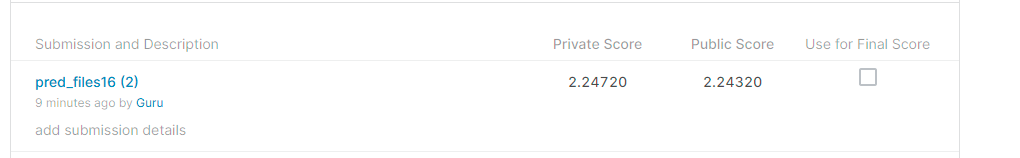

In [17]:
from IPython.display import Image
Image(filename=('/content/Scrnshot-1.png'))

#Rank~230